<a href="https://colab.research.google.com/github/shoboske/facial-emotion-classification-project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import requests
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3  # Using InceptionV3 instead of GoogleNet as it's more readily available
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Download and unzip the dataset
!wget https://github.com/shoboske/facial-emotion-classification-project/raw/refs/heads/main/test.zip
!mkdir -p test_data
!unzip -o test.zip -d test_data


Streaming output truncated to the last 5000 lines.
  inflating: test_data/test/surprise/PublicTest_64107181.jpg  
  inflating: test_data/__MACOSX/test/surprise/._PublicTest_64107181.jpg  
  inflating: test_data/test/surprise/PrivateTest_40404994.jpg  
  inflating: test_data/__MACOSX/test/surprise/._PrivateTest_40404994.jpg  
  inflating: test_data/test/surprise/PrivateTest_34706936.jpg  
  inflating: test_data/__MACOSX/test/surprise/._PrivateTest_34706936.jpg  
  inflating: test_data/test/surprise/PrivateTest_24065334.jpg  
  inflating: test_data/__MACOSX/test/surprise/._PrivateTest_24065334.jpg  
  inflating: test_data/test/surprise/PublicTest_83217196.jpg  
  inflating: test_data/__MACOSX/test/surprise/._PublicTest_83217196.jpg  
  inflating: test_data/test/surprise/PrivateTest_23824214.jpg  
  inflating: test_data/__MACOSX/test/surprise/._PrivateTest_23824214.jpg  
  inflating: test_data/test/surprise/PrivateTest_96333750.jpg  
  inflating: test_data/__MACOSX/test/surprise/._Private

In [2]:

# 2. Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    'test_data/test',
    target_size=(224, 224),  # Input size for InceptionV3
    batch_size=32,
    class_mode='categorical',
    subset='training',
)

validation_generator = train_datagen.flow_from_directory(
    'test_data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 5746 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [ ]:

# 3. Model building (using InceptionV3 as a base)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)  # Add a dense layer
x = Dense(1024, activation='relu')(x)  # Add a dense layer
x = Dense(1024, activation='relu')(x)  # Add a dense layer
x = tf.keras.layers.Dropout(0.2)(x)  # Add a dense layer
predictions = Dense(7, activation='softmax')(x)  # Output layer with 7 classes

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers (optional but recommended initially)
for layer in base_model.layers[:100]:
    layer.trainable = False


In [4]:

# 4. Model compilation and training
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[callback],
    batch_size=32,
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 180s 674ms/step - accuracy: 0.3335 - loss: 1.6683 - val_accuracy: 0.4808 - val_loss: 1.3565
Epoch 2/100
  1/179 ━━━━━━━━━━━━━━━━━━━━ 36s 205ms/step - accuracy: 0.5625 - loss: 1.0526

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.5625 - loss: 1.0526 - val_accuracy: 0.4583 - val_loss: 1.4958
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 475ms/step - accuracy: 0.5647 - loss: 1.1691 - val_accuracy: 0.5341 - val_loss: 1.1917
Epoch 4/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5625 - loss: 1.1524 - val_accuracy: 0.3750 - val_loss: 1.3738
Epoch 5/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 478ms/step - accuracy: 0.6513 - loss: 0.9540 - val_accuracy: 0.5426 - val_loss: 1.2983


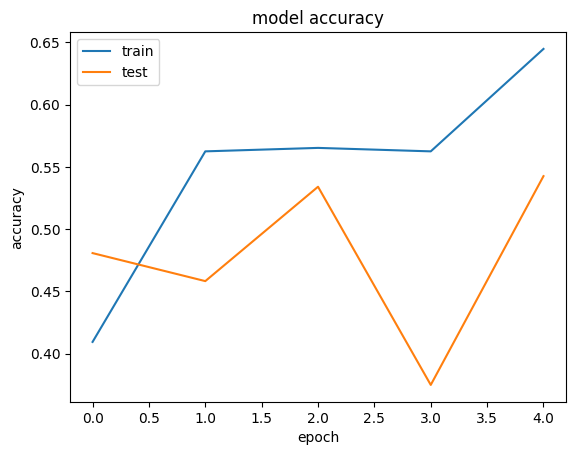

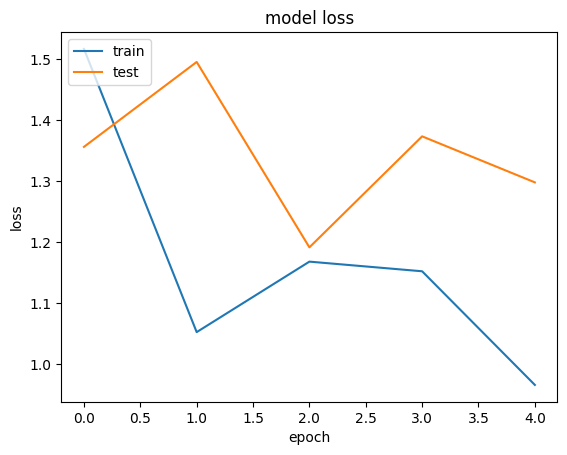

In [5]:
import matplotlib.pyplot as plt
def plot_graph(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

plot_graph(history)

In [6]:

# 5. Model evaluation (optional -  you can add more evaluation metrics)
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.5457 - loss: 1.2554
Validation Loss: 1.304388403892517
Validation Accuracy: 0.549580991268158


45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 358ms/step


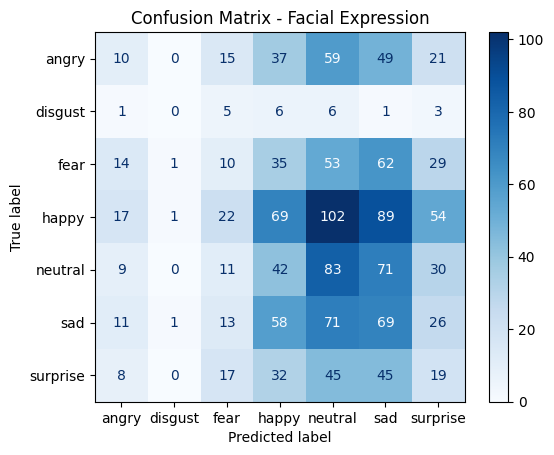

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Get true labels from validation generator
y_true = validation_generator.classes
# Get predicted labels
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=validation_generator.class_indices)
# Assuming your generator has class_indices for labels

disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
plt.title("Confusion Matrix - Facial Expression")
plt.show()
print("\n\n")